In [866]:
import matplotlib.pyplot as plt
import pandas as pd
import os
from tkinter import filedialog
import tkinter as tk
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

In [867]:
# Tkinter attributes, for better code functioning
window = tk.Tk()
window.wm_attributes('-topmost', 1)
window.withdraw()   # this supress the tk window

''

In [868]:
# Asks for the csv file and return data, relative time and velocity
def selectCSV(routeData):
    data = pd.read_csv(routeData)
    relativeT = data['time_rel(sec)']
    velocity = data['velocity(m/s)']
    return data, relativeT, velocity, routeData

In [869]:
from scipy import signal
from matplotlib import cm
from obspy.signal.invsim import cosine_taper
from obspy.signal.filter import highpass
from obspy.signal.trigger import classic_sta_lta, plot_trigger, trigger_onset
from obspy import read

# Asks the MSEED file and returns trace and sampling rate

def selectMSEED(mseedData):
    fileMseed = read(str(mseedData), format = 'MSEED')
    tr = fileMseed[0]
    samplingRate = fileMseed[0].stats.sampling_rate
    return tr, samplingRate

In [870]:
# Implementation of a basic filter for graphical data analysis
def bandpassFilter(mseedFile, minfreq, maxfreq):
    # Going to create a separate trace for the filter data
    st_filt = mseedFile.copy()
    st_filt.filter('bandpass',freqmin=minfreq,freqmax=maxfreq)
    
    tr_filt = st_filt.traces[0].copy()
    tr_times_filt = tr_filt.times()
    tr_data_filt = tr_filt.data

    return tr_filt, tr_times_filt, tr_data_filt

In [871]:
# We make a function that allows you to select detection from preexisting seismic catalogs

# file = filepath
def selectDetection(arrivalTime_Route, file):
    nameCSV = os.path.basename(file)    
    nameCSV, _ = os.path.splitext(nameCSV)
    # Opening the directory
    arrival_time = pd.read_csv(arrivalTime_Route)
    # Establish 'ID' row as index
    arrival_time.set_index('filename', inplace=True)
    arrival = arrival_time.loc[nameCSV, 'time_rel(sec)']
    return arrival

In [872]:
#Make catalog plots 

def catalogPlot(relTime, velocity, sampling_rate, arrivalTime, title):

    colors = ['#1e1e1e', '#b100e8', '#048aff', '#01237d']
    custom_cmap = LinearSegmentedColormap.from_list('custom_purple', colors, N=256)
    f, t, sxx = signal.spectrogram(velocity, sampling_rate)

    vmax = np.percentile(sxx, 99.95)
    # Plot the time series and spectrogram
    fig = plt.figure(figsize=(10, 10), facecolor= '#1e1e1e', dpi=300)
    ax = plt.subplot(2, 1, 1)
    # Plot trace
    ax.plot(relTime,velocity, color = '#b100e8')
    ax.set_title(title, color = '#fffaeb')
    ax.set_facecolor('#1e1e1e')
    ax.tick_params(axis='x', colors='#fffaeb')
    ax.tick_params(axis='y', colors='#fffaeb')

    # Mark detection
    #ax.axvline(x = arrivalTime, color='red',label='Detection')
    ax.legend(loc='upper left')

    # Make the plot pretty
    ax.set_xlim([min(relTime),max(relTime)])
    ax.set_ylabel('Velocity (m/s)', fontweight='bold', color = '#fffaeb')
    ax.set_xlabel('Time (s)', fontweight='bold', color = '#fffaeb')

    ax2 = plt.subplot(2, 1, 2, facecolor= '#1e1e1e')
    ax2.set_title(title, color = '#fffaeb')
    vals = ax2.pcolormesh(t, f, sxx, cmap=custom_cmap, vmax = vmax)
    ax2.set_xlim([min(relTime),max(relTime)])
    #ax2.set_ylim([0,7])
    ax2.set_xlabel(f'Time (Day Hour:Minute)', fontweight='bold', color = '#fffaeb')
    ax2.set_ylabel('Frequency (Hz)', fontweight='bold', color = '#fffaeb')
    #ax2.axvline(x=arrivalTime, c='red')
    ax2.set_facecolor('#1e1e1e')
    ax2.tick_params(axis='x', colors='#fffaeb')
    ax2.tick_params(axis='y', colors='#fffaeb')
    cbar = plt.colorbar(vals, orientation='horizontal')
    cbar.set_label('Power ((m/s)^2/sqrt(Hz))', fontweight='bold', color = '#fffaeb')

    current_directory = os.getcwd()
    file_path = os.path.join(current_directory, 'high_res_plot.png')
    title = os.path.basename(title)    
    title, _ = os.path.splitext(title)
    plt.savefig(file_path + title + 'plot.png', dpi=300)
    plt.show()

C:\Users\Gabriel Dittel\AppData\Local\Temp\ipykernel_11904\390682384.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper left')


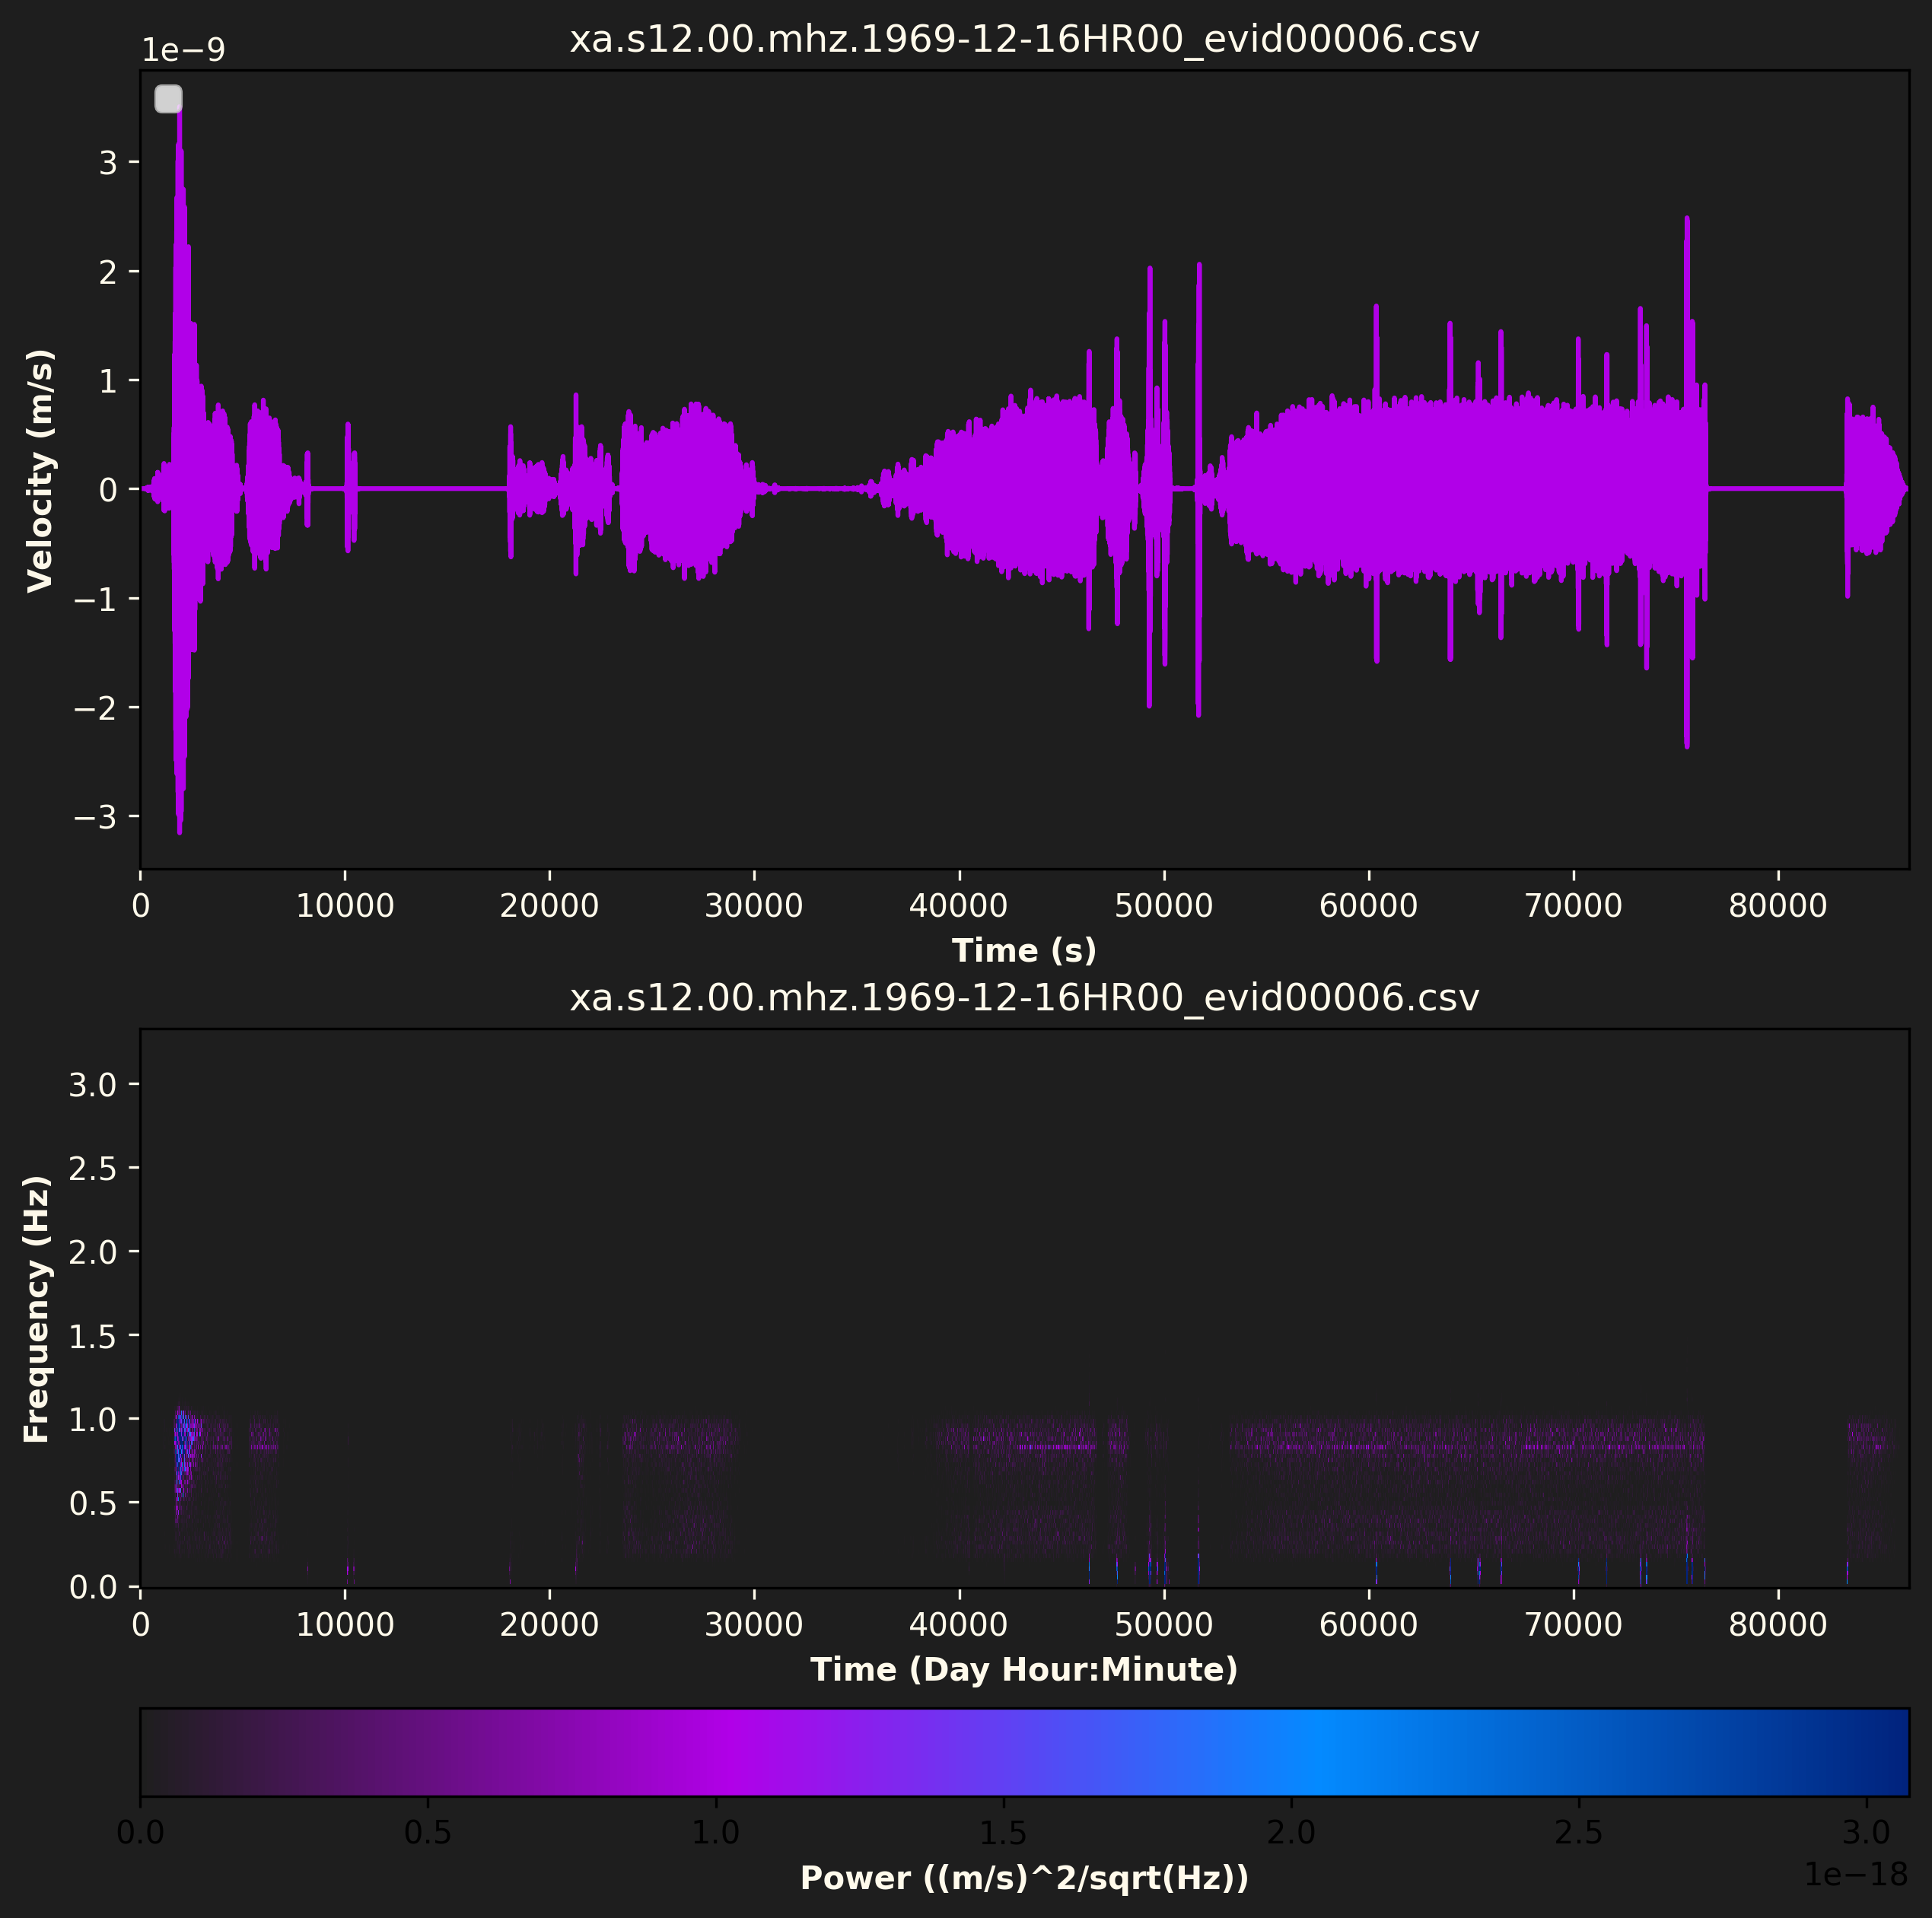

In [873]:
# Code iteration 

# Open file dialog to select multiple files
filePaths_CSV = filedialog.askopenfilenames(
    initialdir="",
    title="Select seismic data files",
    filetypes=[("CSV files", "*.csv")]
)


filePaths_mseed = filedialog.askopenfilenames(
    initialdir="",
    title="Elija archivo de datos",
    filetypes=[("MSEED files", "*.mseed")]
)


filePaths_catalogs = filedialog.askopenfilenames(
    initialdir="",
    title="Select a seismic detection catalog",
    filetypes=[("CSV files", "*.csv")]
)

# Extract the catalog
catalog = filePaths_catalogs[0]

# Alphabetical sorting for both CSV and mseed
filePaths_CSV = sorted(filePaths_CSV)
filePaths_mseed = sorted(filePaths_mseed)

# First it needs to check they are the same length
if len(filePaths_CSV) != len(filePaths_mseed):
      print('CSV data and mseeds are needed to be the same ammounts')
else:
    for csv, mseed in zip(filePaths_CSV, filePaths_mseed):
            
            # Verify they're same seed and csv from the same
            nameCSV = os.path.basename(csv)    
            nameCSV, _ = os.path.splitext(csv)
            nameMSEED = os.path.basename(mseed)    
            nameMSEED, _ = os.path.splitext(mseed)
            if nameCSV != nameMSEED:
                  print('MSEED or CSV missing, please select both for files for an evidence')
                  break
            
            # Utilize the functions in order to read the CSV an MSEED data, then generates a catalog plot
            data, relTime, velocity, filename = selectCSV(csv)
            trace, sampling_rate = selectMSEED(mseed)
            arrivalTime = 1 #selectDetection(catalog, filename)
            title = os.path.basename(filename)
            catalogPlot(relTime, velocity, sampling_rate, arrivalTime, title)